# DATA ANALYSIS - CLUSTER EXAMINATION (EXTENDED VERSION)

`Author: José Luis Maldonado Álvarez`

## K-MEANS

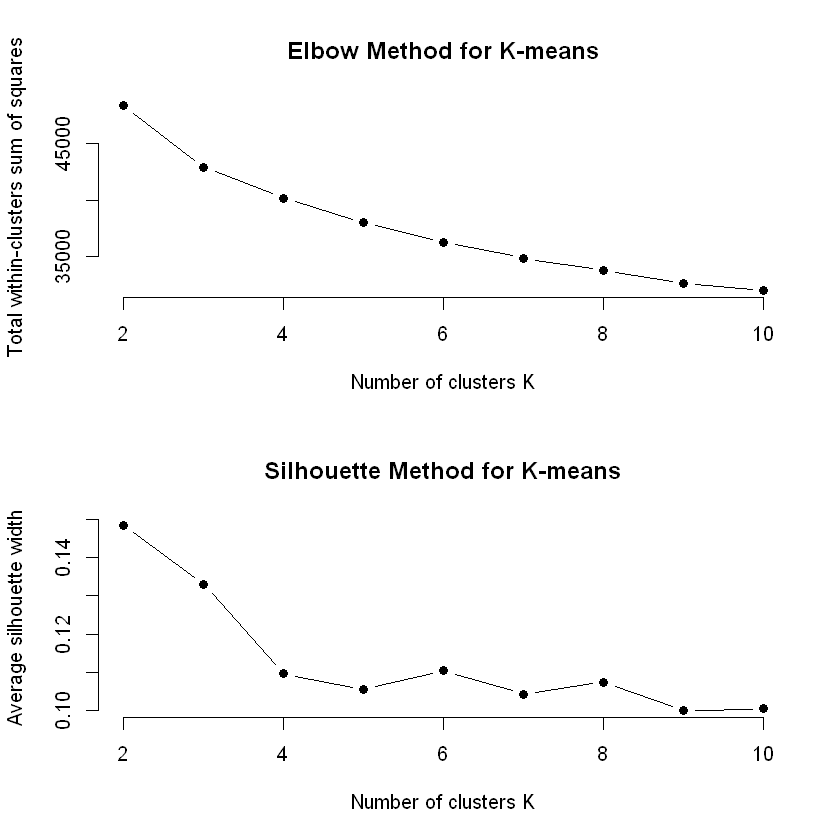

In [1]:
suppressPackageStartupMessages(library(cluster))
suppressPackageStartupMessages(library(dplyr))

# Load data and select only variables that start with 'SE_'
df <- read.csv('FINAL_DATASET.csv')
se_vars <- df %>%
    select(starts_with("SE_")) %>%
    mutate(across(everything(), as.factor)) %>%
    select(-c(SE_GCHI, SE_CHI, SE_LA, SE_SN, SE_PC, SE_MP, SE_WT, SE_PUBT, SE_PI, SE_PRIT))
    

# Determine the optimal number of clusters for k-means using the elbow and silhouette methods
set.seed(123)

# Compute the dissimilarity matrix using daisy (suitable for factors)
diss <- daisy(se_vars, metric = "gower")
diss_matrix <- as.matrix(diss)

wss <- numeric()
sil_width <- numeric()
max_k <- 10

for (k in 2:max_k) {
    kmeans_res <- kmeans(diss_matrix, centers = k, nstart = 10)
    wss[k] <- kmeans_res$tot.withinss
    cluster_assign <- kmeans_res$cluster
    sil <- silhouette(cluster_assign, dist = diss_matrix)
    sil_width[k] <- mean(sil[, 3])
}

# Plot the elbow method (within-cluster sum of squares)
par(bg= "white", mfrow = c(2, 1))
plot(2:max_k, wss[2:max_k], type = "b", pch = 19, frame = FALSE,
     xlab = "Number of clusters K", ylab = "Total within-clusters sum of squares",
     main = "Elbow Method for K-means")

# Plot the average silhouette width
plot(2:max_k, sil_width[2:max_k], type = "b", pch = 19, frame = FALSE,
     xlab = "Number of clusters K", ylab = "Average silhouette width",
     main = "Silhouette Method for K-means")


Variable: SE_MS 
   
      1   2   3
  1 274 599 616
  2 255 189 176

Variable: SE_SUP 
   
      1   2   3
  0  32  16   7
  1 497 772 785

Variable: SE_RES 
   
      1   2   3
  1 343 336 524
  2 186 452 268

Variable: SE_STU 
   
      1   2   3
  1 409 120 680
  2 120 668 112

Variable: SE_OCC 
   
      1   2   3
  1 396 358 743
  2 133 430  49

Variable: SE_EX 
   
      1   2   3
  0 344 295 110
  1 185 493 682

Variable: SE_HW 
   
      1   2   3
  0 293 446 429
  1 236 342 363

Variable: SE_PET 
   
      1   2   3
  0 263 468 588
  1 266 320 204

Variable: SE_INT 
   
      1   2   3
  0 236  16 228
  1 293 772 564

Variable: SE_TSI 
   
      1   2   3
  0 321 700 685
  1 208  88 107

Variable: SE_ACTT 
   
      1   2   3
  0 280 281  83
  1 249 507 709

Variable: SE_SH 
   
      1   2   3
  0  36   3   1
  1 493 785 791

Variable: SE_TEH 
   
      1   2   3
  0  47  25   5
  1 482 763 787

Variable: SE_CCH 
   
      1   2   3
  0 279  49 154
  1 250 739 638

Variable

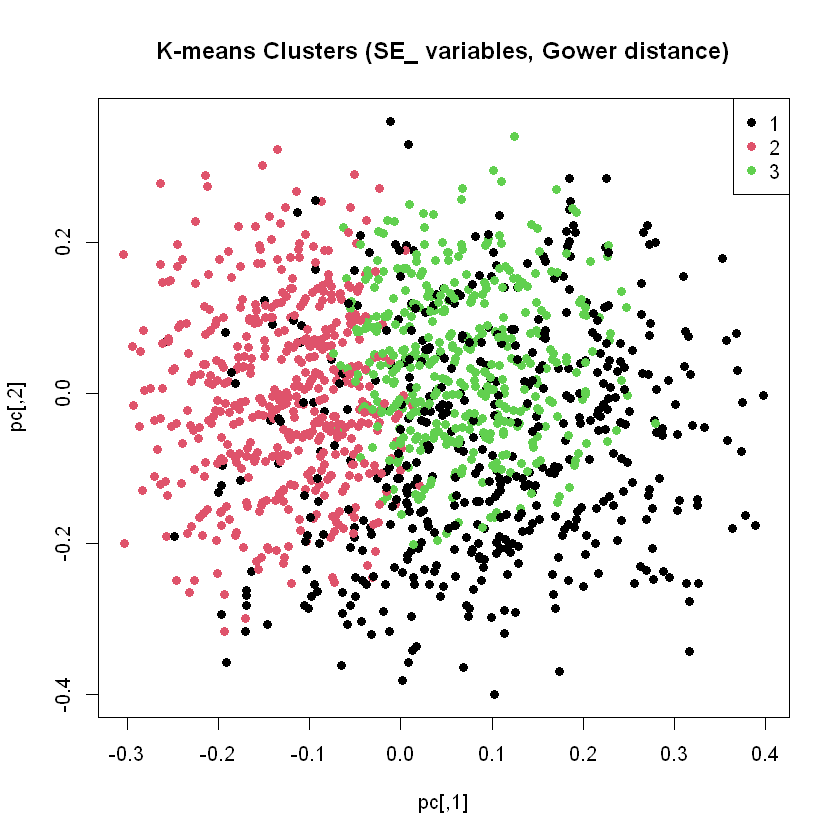

In [2]:
# Chosen number of clusters k = 3
set.seed(123)
k <- 3
kmeans_result <- kmeans(as.matrix(diss), centers = k)

# Add cluster assignment to the data
se_vars$cluster <- as.factor(kmeans_result$cluster)

# Visualize clusters using first two principal coordinates
pc <- cmdscale(diss, k = 2)
par(bg = "white")
plot(pc, col = se_vars$cluster, pch = 19, main = "K-means Clusters (SE_ variables, Gower distance)")
legend("topright", legend = levels(se_vars$cluster), col = 1:k, pch = 19)

# # Analyze the characteristics of each cluster
# cluster_summary <- se_vars %>%
#     group_by(cluster) %>%
#     summarise(across(where(is.factor), ~paste0(names(sort(table(.), decreasing = TRUE)[1]), " (", max(table(.)), ")"), .names = "mode_{.col}"),
#               count = n())
# print(cluster_summary)

# Show the distribution of each SE_ variable by cluster
for (var in names(se_vars)[names(se_vars) != "cluster"]) {
    cat("\nVariable:", var, "\n")
    print(table(se_vars[[var]], se_vars$cluster))
}

In [3]:
# Print the distribution of OUT_MACE variable for each cluster from kmeans_result
mace_by_cluster <- table(df$OUT_MACE, se_vars$cluster)
cat("\nMACE distribution by clusters:")
print(mace_by_cluster)

# Calculate and print percentage of OUT_MACE == 1 for each cluster
cat("\nMACE percentage of occurence by  clusters:\n")
percent_mace1 <- prop.table(mace_by_cluster, 2)["1", ] * 100
print(round(percent_mace1, 2))



MACE distribution by clusters:   
      1   2   3
  0 412 657 632
  1 117 131 160

MACE percentage of occurence by  clusters:
    1     2     3 
22.12 16.62 20.20 


Warning message:
"package 'fmsb' was built under R version 4.4.3"
Warning message:
"Setting row names on a tibble is deprecated."


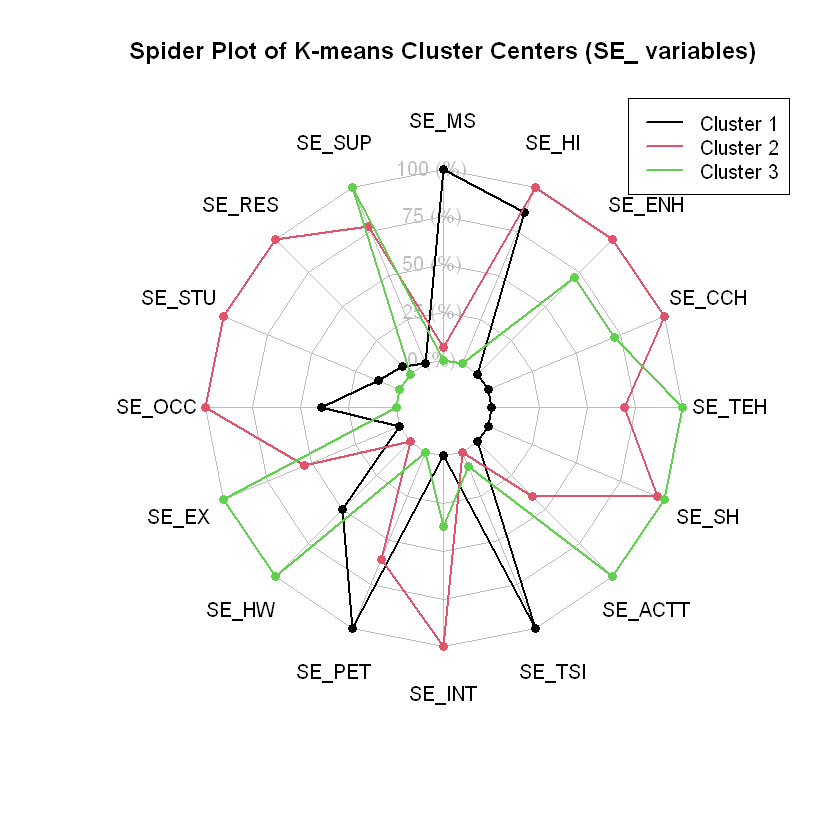

In [4]:
# Spider (radar) plot of cluster centers from kmeans_result

suppressPackageStartupMessages(library(fmsb))

# Extract cluster centers (on dissimilarity matrix, so not interpretable per variable)
# Instead, compute mode for each SE_ variable per cluster for visualization

# Prepare data: convert factors to numeric for radar plot
se_numeric <- df %>%
    select(starts_with("SE_")) %>%
    mutate(across(everything(), ~as.numeric(as.factor(.)))) %>%
    select(-c(SE_GCHI, SE_CHI, SE_LA, SE_SN, SE_PC, SE_MP, SE_WT, SE_PUBT, SE_PI, SE_PRIT))

cluster_centers <- se_numeric %>%
    mutate(cluster = kmeans_result$cluster) %>%
    group_by(cluster) %>%
    summarise(across(everything(), mean))

# fmsb requires max/min rows
max_vals <- apply(cluster_centers[,-1], 2, max)
min_vals <- apply(cluster_centers[,-1], 2, min)
radar_data <- rbind(max_vals, min_vals, cluster_centers[,-1])

# Set row names for clarity
rownames(radar_data) <- c("Max", "Min", paste0("Cluster_", cluster_centers$cluster))

# Plot
par(bg = "white")
radarchart(radar_data, axistype = 1,
           title = "Spider Plot of K-means Cluster Centers (SE_ variables)",
           pcol = 1:k, plwd = 2, plty = 1, cglcol = "grey", cglty = 1, axislabcol = "grey")
legend("topright", legend = paste0("Cluster ", cluster_centers$cluster), col = 1:k, lty = 1, lwd = 2)

## PAM ()

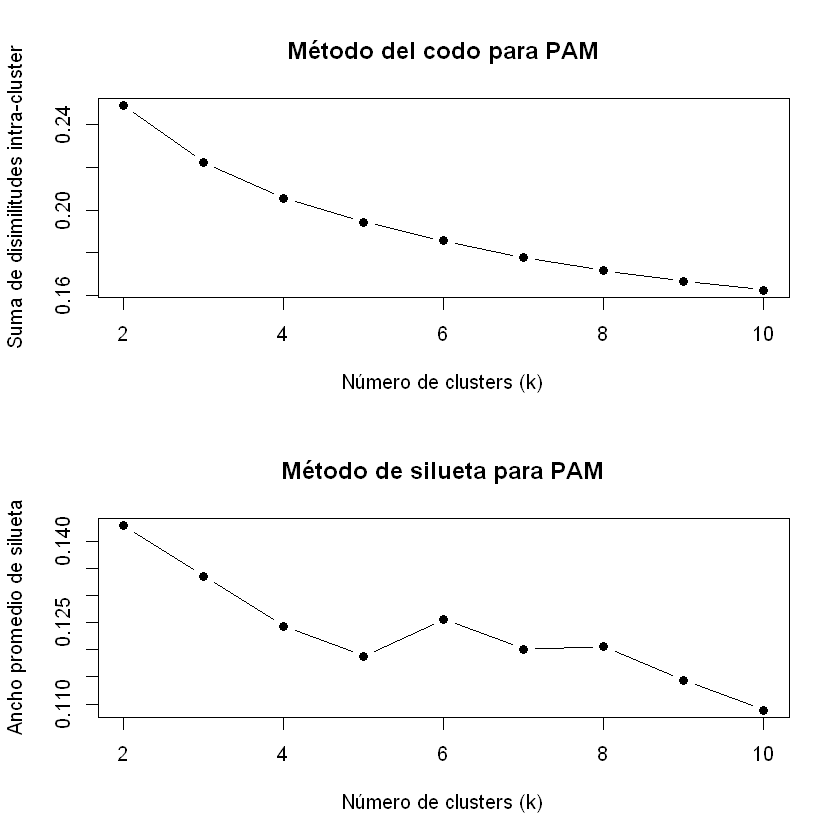

In [5]:
# Remove any cluster columns if present
se_vars_pam <- se_vars %>%
    select(-matches("^cluster"))

# Compute the dissimilarity matrix using daisy (already done above)
diss_pam <- daisy(se_vars_pam, metric = "gower")

wss <- numeric(9)
sil_width <- numeric(9)
for (k in 2:10) {
    pam_fit <- pam(diss_pam, k, diss = TRUE)
    wss[k - 1] <- pam_fit$objective[1]
    sil_width[k - 1] <- pam_fit$silinfo$avg.width
}

# Plot elbow method
par(bg = "white", mfrow = c(2, 1))
plot(2:10, wss, type = "b", pch = 19, xlab = "Número de clusters (k)", ylab = "Suma de disimilitudes intra-cluster",
     main = "Método del codo para PAM")

# Plot silhouette method
plot(2:10, sil_width, type = "b", pch = 19, xlab = "Número de clusters (k)", ylab = "Ancho promedio de silueta",
     main = "Método de silueta para PAM")


Variable: SE_MS 
   
      1   2   3   4   5
  1 329 354 365 292 149
  2  95  60 119  50 296

Variable: SE_SUP 
   
      1   2   3   4   5
  0   6   2  17   1  29
  1 418 412 467 341 416

Variable: SE_RES 
   
      1   2   3   4   5
  1 331 286  62 232 292
  2  93 128 422 110 153

Variable: SE_STU 
   
      1   2   3   4   5
  1 111 381  93 256 368
  2 313  33 391  86  77

Variable: SE_OCC 
   
      1   2   3   4   5
  1 121 378 342 248 408
  2 303  36 142  94  37

Variable: SE_EX 
   
      1   2   3   4   5
  0 124  91 115 270 149
  1 300 323 369  72 296

Variable: SE_HW 
   
      1   2   3   4   5
  0 305 321 150 277 115
  1 119  93 334  65 330

Variable: SE_PET 
   
      1   2   3   4   5
  0 129 338 392  96 364
  1 295  76  92 246  81

Variable: SE_INT 
   
      1   2   3   4   5
  0  14 105  40  57 264
  1 410 309 444 285 181

Variable: SE_TSI 
   
      1   2   3   4   5
  0 370 338 414 260 324
  1  54  76  70  82 121

Variable: SE_ACTT 
   
      1   2   3   4   5
  0 1

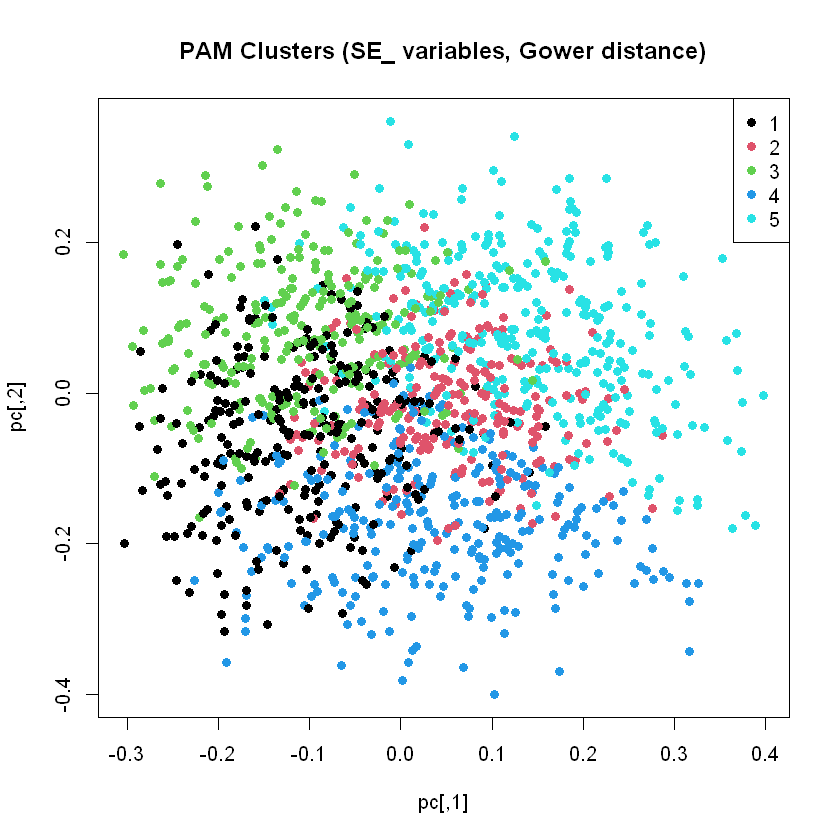

In [6]:
# PAM (Partitioning Around Medoids) clustering using Gower distance

# Remove any cluster columns if present
se_vars_pam <- se_vars %>%
    select(-matches("^cluster"))

# Compute the dissimilarity matrix using daisy (already done above)
# diss <- daisy(se_vars, metric = "gower")

set.seed(123)
k <- 5
pam_result <- pam(diss, k)

# Add cluster assignment to the data
se_vars$cluster_pam <- as.factor(pam_result$clustering)

# Visualize clusters using first two principal coordinates
pc <- cmdscale(diss, k = 2)
par(bg = "white")
plot(pc, col = se_vars$cluster_pam, pch = 19, main = "PAM Clusters (SE_ variables, Gower distance)")
legend("topright", legend = levels(se_vars$cluster_pam), col = 1:k, pch = 19)

# # Analyze the characteristics of each cluster
# cluster_summary_pam <- se_vars %>%
#     group_by(cluster_pam) %>%
#     summarise(across(where(is.factor), ~paste0(names(sort(table(.), decreasing = TRUE)[1]), " (", max(table(.)), ")"), .names = "mode_{.col}"),
#               count = n())

# print(cluster_summary_pam)

# Show the distribution of each SE_ variable by cluster
for (var in names(se_vars)[names(se_vars) != "cluster_pam"]) {
    cat("\nVariable:", var, "\n")
    print(table(se_vars[[var]], se_vars$cluster_pam))
}

Warning message:
"Setting row names on a tibble is deprecated."


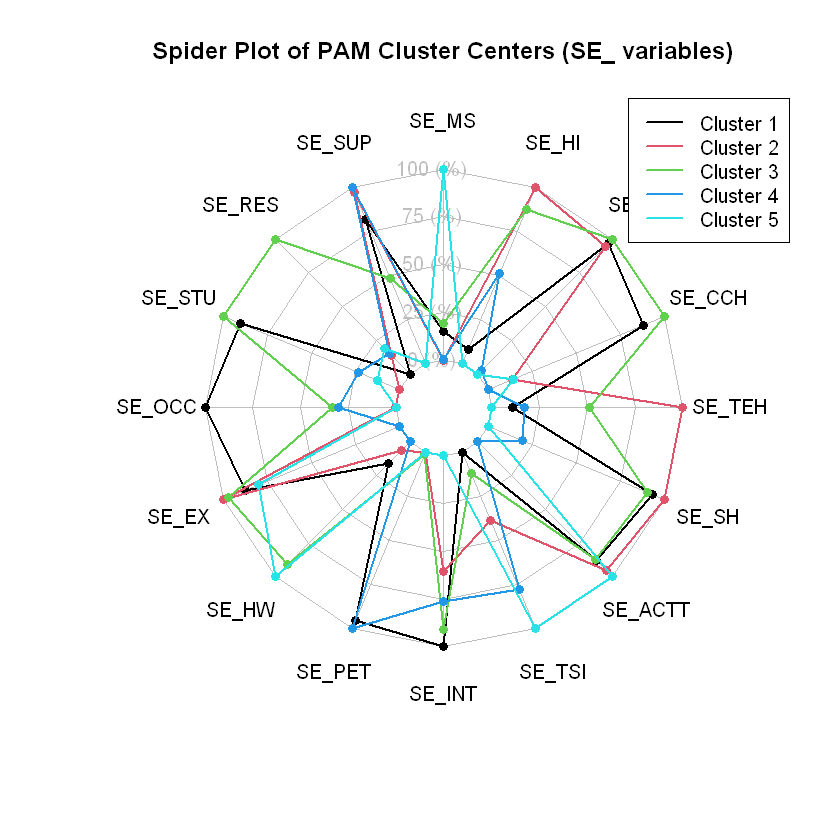

In [7]:
# Spider (radar) plot of cluster centers from pam_result

# Prepare data: convert factors to numeric for radar plot
se_numeric_pam <- se_vars %>%
    select(-cluster, -cluster_pam) %>%
    mutate(across(everything(), ~as.numeric(as.factor(.))))

cluster_centers_pam <- se_numeric_pam %>%
    mutate(cluster_pam = pam_result$clustering) %>%
    group_by(cluster_pam) %>%
    summarise(across(everything(), mean))

# fmsb requires max/min rows
max_vals_pam <- apply(cluster_centers_pam[,-1], 2, max)
min_vals_pam <- apply(cluster_centers_pam[,-1], 2, min)
radar_data_pam <- rbind(max_vals_pam, min_vals_pam, cluster_centers_pam[,-1])

# Set row names for clarity
rownames(radar_data_pam) <- c("Max", "Min", paste0("Cluster_", cluster_centers_pam$cluster_pam))

# Plot
par(bg = "white")
radarchart(radar_data_pam, axistype = 1,
           title = "Spider Plot of PAM Cluster Centers (SE_ variables)",
           pcol = 1:k, plwd = 2, plty = 1, cglcol = "grey", cglty = 1, axislabcol = "grey")
legend("topright", legend = paste0("Cluster ", cluster_centers_pam$cluster_pam), col = 1:k, lty = 1, lwd = 2)

In [8]:
# Print the distribution of OUT_MACE variable for each cluster from pam_result
mace_by_pam_cluster <- table(df$OUT_MACE, se_vars$cluster_pam)
cat("\nMACE distribution by clusters:")
print(mace_by_pam_cluster)

# Calculate and print percentage of OUT_MACE == 1 for each cluster
cat("\nMACE percentage of occurence by clusters:\n")
percent_mace1 <- prop.table(mace_by_pam_cluster, 2)["1", ] * 100
print(round(percent_mace1, 2))



MACE distribution by clusters:   
      1   2   3   4   5
  0 360 319 399 280 343
  1  64  95  85  62 102

MACE percentage of occurence by clusters:
    1     2     3     4     5 
15.09 22.95 17.56 18.13 22.92 


## 3. Hierarchical clustering


Variable: SE_MS 
   
      1   2   3
  1 892 158 439
  2 114 396 110

Variable: SE_SUP 
   
      1   2   3
  0   7  35  13
  1 999 519 536

Variable: SE_RES 
   
      1   2   3
  1 779 347  77
  2 227 207 472

Variable: SE_STU 
   
      1   2   3
  1 686 388 135
  2 320 166 414

Variable: SE_OCC 
   
      1   2   3
  1 690 411 396
  2 316 143 153

Variable: SE_EX 
   
      1   2   3
  0 410 195 144
  1 596 359 405

Variable: SE_HW 
   
      1   2   3
  0 749 135 284
  1 257 419 265

Variable: SE_PET 
   
      1   2   3
  0 429 447 443
  1 577 107 106

Variable: SE_INT 
   
      1   2   3
  0 190 247  43
  1 816 307 506

Variable: SE_TSI 
   
      1   2   3
  0 811 429 466
  1 195 125  83

Variable: SE_ACTT 
   
      1   2   3
  0 393  94 157
  1 613 460 392

Variable: SE_SH 
   
      1   2   3
  0  19  17   4
  1 987 537 545

Variable: SE_TEH 
   
      1   2   3
  0  46  18  13
  1 960 536 536

Variable: SE_CCH 
   
      1   2   3
  0 327 109  46
  1 679 445 503

Variable

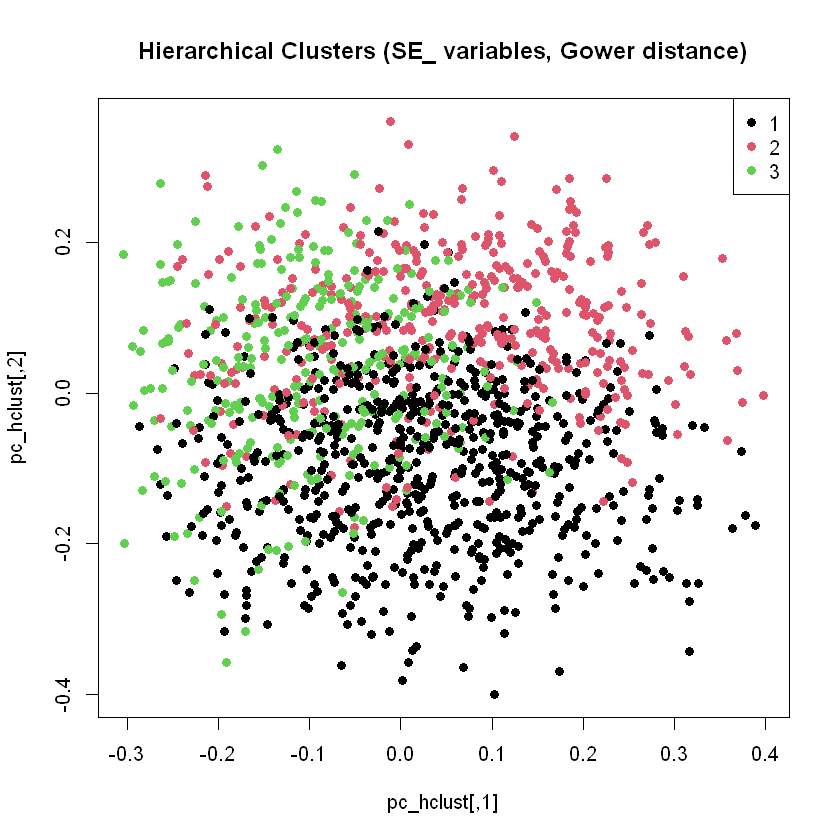

In [9]:
# Hierarchical clustering using hclust on Gower distance

# Select only the variables that start with 'SE_'
se_vars_hclust <- df %>% select(starts_with("SE_")) %>%
    mutate(across(everything(), as.factor)) %>%
    select(-c(SE_GCHI, SE_CHI, SE_LA, SE_SN, SE_PC, SE_MP, SE_WT, SE_PUBT, SE_PI, SE_PRIT))

# Compute the dissimilarity matrix using daisy (suitable for factors)
diss_hclust <- daisy(se_vars_hclust, metric = "gower")

# Perform hierarchical clustering
hc <- hclust(as.dist(diss_hclust), method = "ward.D2")

# Choose number of clusters (e.g., 3, can be adjusted)
k <- 3
clusters_hclust <- cutree(hc, k = k)

# Add cluster assignment to the data
se_vars_hclust$cluster_hclust <- as.factor(clusters_hclust)

# Visualize clusters using first two principal coordinates
pc_hclust <- cmdscale(diss_hclust, k = 2)
par(bg = "white")
plot(pc_hclust, col = se_vars_hclust$cluster_hclust, pch = 19, main = "Hierarchical Clusters (SE_ variables, Gower distance)")
legend("topright", legend = levels(se_vars_hclust$cluster_hclust), col = 1:k, pch = 19)

# # Analyze the characteristics of each cluster
# cluster_summary_hclust <- se_vars_hclust %>%
#     group_by(cluster_hclust) %>%
#     summarise(across(where(is.factor), ~paste0(names(sort(table(.), decreasing = TRUE)[1]), " (", max(table(.)), ")"), .names = "mode_{.col}"),
#               count = n())

# print(cluster_summary_hclust)

# Show the distribution of each SE_ variable by cluster
for (var in names(se_vars_hclust)[names(se_vars_hclust) != "cluster_hclust"]) {
    cat("\nVariable:", var, "\n")
    print(table(se_vars_hclust[[var]], se_vars_hclust$cluster_hclust))
}

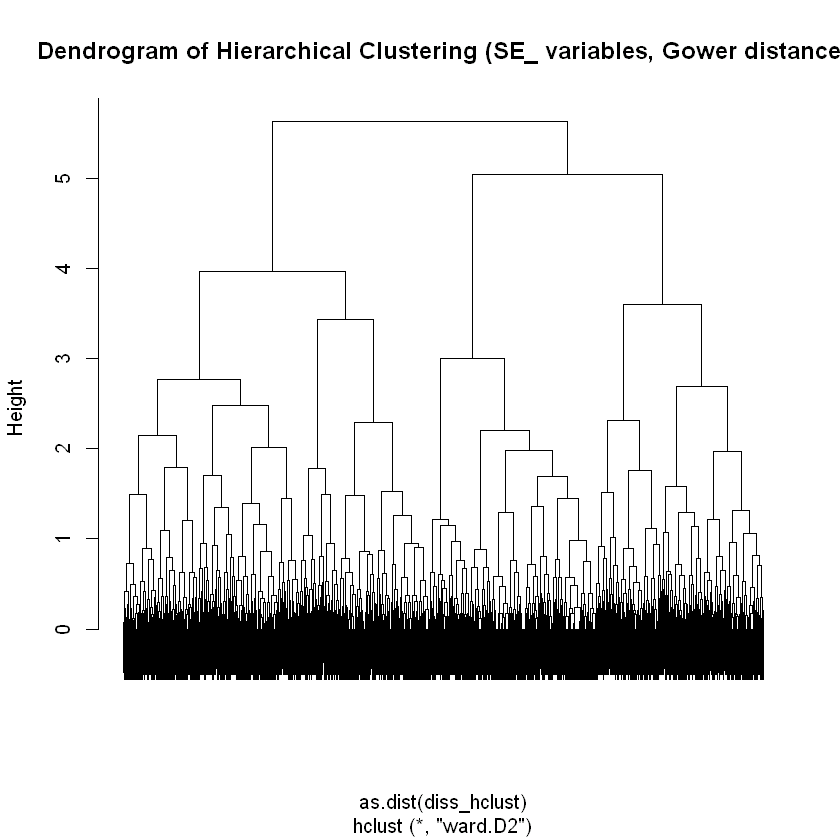

In [10]:
plot(hc, labels = FALSE, main = "Dendrogram of Hierarchical Clustering (SE_ variables, Gower distance)")

Warning message:
"Setting row names on a tibble is deprecated."


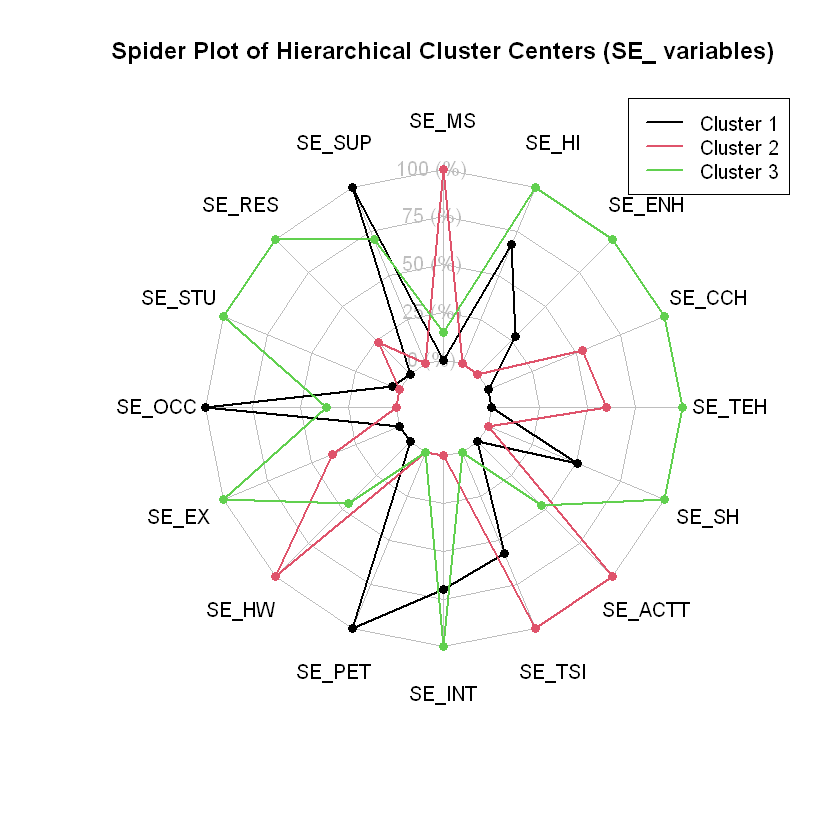

In [11]:
# Spider (radar) plot of cluster centers from hierarchical clustering

# Prepare data: convert factors to numeric for radar plot
se_numeric_hclust <- se_vars_hclust %>%
    select(-cluster_hclust) %>%
    mutate(across(everything(), ~as.numeric(as.factor(.))))

cluster_centers_hclust <- se_numeric_hclust %>%
    mutate(cluster_hclust = clusters_hclust) %>%
    group_by(cluster_hclust) %>%
    summarise(across(everything(), mean))

# fmsb requires max/min rows
max_vals_hclust <- apply(cluster_centers_hclust[,-1], 2, max)
min_vals_hclust <- apply(cluster_centers_hclust[,-1], 2, min)
radar_data_hclust <- rbind(max_vals_hclust, min_vals_hclust, cluster_centers_hclust[,-1])

# Set row names for clarity
rownames(radar_data_hclust) <- c("Max", "Min", paste0("Cluster_", cluster_centers_hclust$cluster_hclust))

# Plot
par(bg = "white")
radarchart(radar_data_hclust, axistype = 1,
           title = "Spider Plot of Hierarchical Cluster Centers (SE_ variables)",
           pcol = 1:k, plwd = 2, plty = 1, cglcol = "grey", cglty = 1, axislabcol = "grey")
legend("topright", legend = paste0("Cluster ", cluster_centers_hclust$cluster_hclust), col = 1:k, lty = 1, lwd = 2)

In [12]:
# Print the distribution of OUT_MACE variable for each cluster from hierarchical clustering
cat("\nMACE distribution by clusters:")
mace_by_hclust_cluster <- table(df$OUT_MACE, se_vars_hclust$cluster_hclust)
print(mace_by_hclust_cluster)

# Calculate and print percentage of OUT_MACE == 1 for each cluster
cat("\nMACE percentage of occurence by clusters:\n")
percent_mace1 <- prop.table(mace_by_hclust_cluster, 2)["1", ] * 100
print(round(percent_mace1, 2))


MACE distribution by clusters:

   
      1   2   3
  0 814 431 456
  1 192 123  93

MACE percentage of occurence by clusters:
    1     2     3 
19.09 22.20 16.94 


## 4. KModes

Warning message:
"package 'klaR' was built under R version 4.4.2"


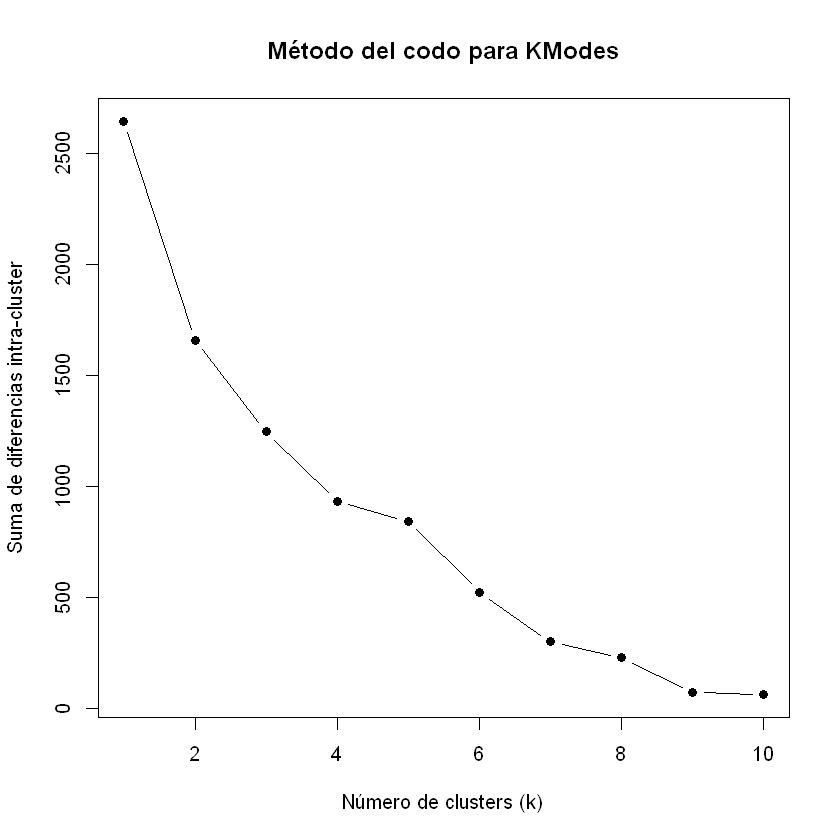

In [13]:
# KModes clustering for categorical data
suppressPackageStartupMessages(library(cluster))
suppressPackageStartupMessages(library(dplyr))

# Load data and select only variables that start with 'SE_'
df <- read.csv('FINAL_DATASET.csv')
se_vars <- df %>%
    select(c(SE_MS, SE_STU, SE_HI))
    # select(starts_with("SE_")) %>%
    # mutate(across(everything(), as.factor)) %>%
    # select(-c(SE_GCHI, SE_CHI, SE_LA, SE_SN, SE_PC, SE_MP, SE_WT, SE_PUBT, SE_PI, SE_PRIT))

# Prepare data: se_vars already contains only factor variables (excluding cluster assignments)
# Remove any cluster columns if present
se_vars_kmodes <- se_vars %>%
    select(-matches("^cluster"))

suppressPackageStartupMessages(library(klaR))

set.seed(123)
max_k <- 10
withindiff_vec <- numeric(max_k)

for (k in 1:max_k) {
    km_res <- suppressWarnings(kmodes(se_vars_kmodes, modes = k, iter.max = 20))
    withindiff_vec[k] <- sum(km_res$withindiff)
}
par(bg = "white")
plot(1:max_k, withindiff_vec, type = "b", pch = 19,
     xlab = "Número de clusters (k)", ylab = "Suma de diferencias intra-cluster",
     main = "Método del codo para KModes")

In [14]:
set.seed(123)
k <- 4
kmodes_result <- kmodes(se_vars_kmodes, modes = k, iter.max = 20)

# Add cluster assignment to the data
se_vars$cluster_kmodes <- as.factor(kmodes_result$cluster)

# Show the distribution of each SE_ variable by cluster
for (var in names(se_vars)[names(se_vars) != "cluster_kmodes"]) {
    cat("\nVariable:", var, "\n")
    print(table(se_vars[[var]], se_vars$cluster_kmodes))
}

# Print the distribution of OUT_MACE variable for each KModes cluster
mace_by_kmodes_cluster <- table(df$OUT_MACE, se_vars$cluster_kmodes)
print(mace_by_kmodes_cluster)
# Print percentages for each OUT_MACE value within each cluster
percent_mace_kmodes <- prop.table(mace_by_kmodes_cluster, 2) * 100
print(round(percent_mace_kmodes, 2))



Variable: SE_MS 
   
      1   2   3   4
  1 550 118 142 679
  2  37 230 297  56

Variable: SE_STU 
   
      1   2   3   4
  1 135  51 403 620
  2 452 297  36 115

Variable: SE_HI 
                  
                     1   2   3   4
  (30707,34138.7]  435  43 361 139
  (34138.7, 76251] 117 295  49 525
  [25649,30707]     35  10  29  71
   
      1   2   3   4
  0 480 287 339 595
  1 107  61 100 140
   
        1     2     3     4
  0 81.77 82.47 77.22 80.95
  1 18.23 17.53 22.78 19.05


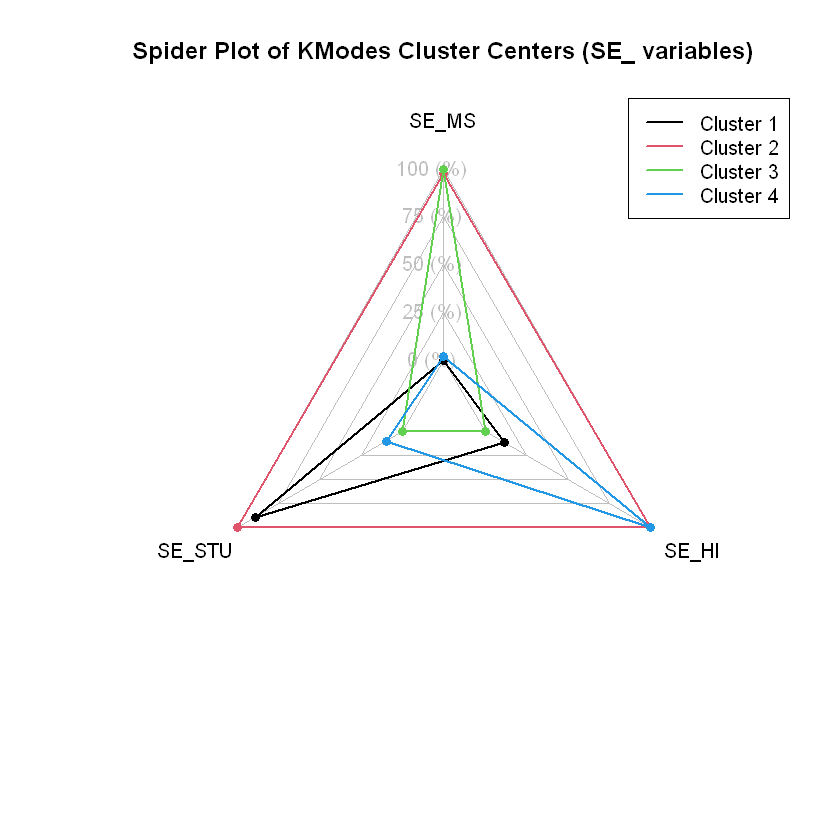

In [15]:
# Spider (radar) plot of cluster centers from KModes clustering
suppressPackageStartupMessages(library(fmsb))

# Prepare data: convert factors to numeric for radar plot
se_numeric_kmodes <- se_vars
se_numeric_kmodes$cluster_kmodes <- as.factor(se_numeric_kmodes$cluster_kmodes)
for (col in names(se_numeric_kmodes)[names(se_numeric_kmodes) != "cluster_kmodes"]) {
    se_numeric_kmodes[[col]] <- as.numeric(as.factor(se_numeric_kmodes[[col]]))
}

# Calculate cluster centers (means) for each variable by cluster
cluster_centers_kmodes <- aggregate(. ~ cluster_kmodes, data = se_numeric_kmodes, FUN = mean)

# fmsb requires max/min rows
max_vals_kmodes <- apply(cluster_centers_kmodes[,-1], 2, max)
min_vals_kmodes <- apply(cluster_centers_kmodes[,-1], 2, min)
radar_data_kmodes <- rbind(max_vals_kmodes, min_vals_kmodes, cluster_centers_kmodes[,-1])

# Set row names for clarity
rownames(radar_data_kmodes) <- c("Max", "Min", paste0("Cluster_", cluster_centers_kmodes$cluster_kmodes))

# Plot
par(bg = "white")
radarchart(radar_data_kmodes, axistype = 1,
           title = "Spider Plot of KModes Cluster Centers (SE_ variables)",
           pcol = 1:k, plwd = 2, plty = 1, cglcol = "grey", cglty = 1, axislabcol = "grey")
legend("topright", legend = paste0("Cluster ", cluster_centers_kmodes$cluster_kmodes), col = 1:k, lty = 1, lwd = 2)

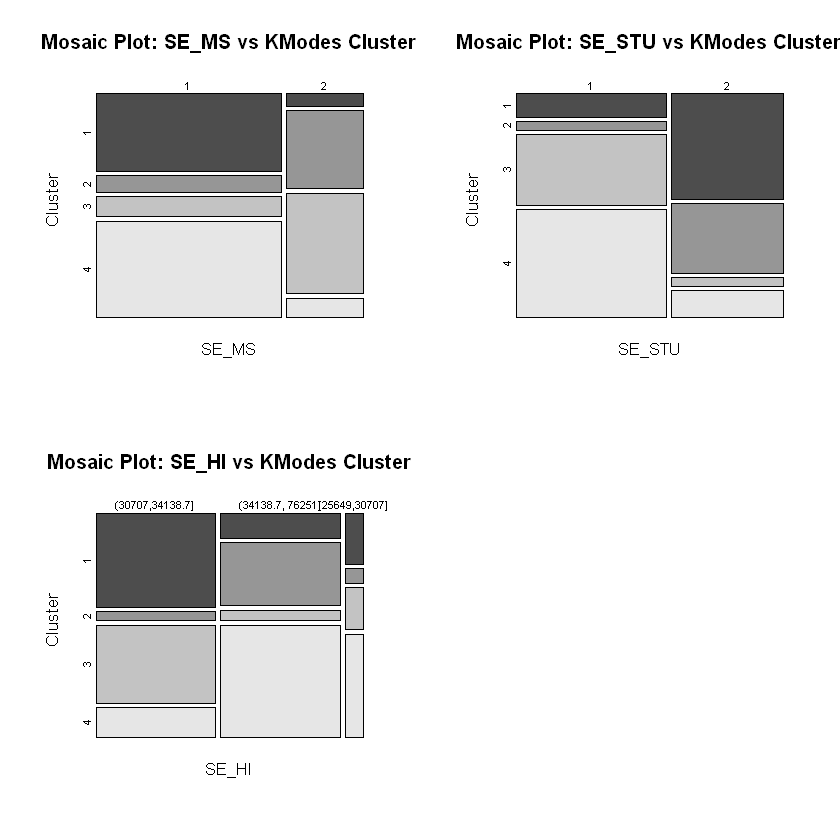

In [16]:
par(bg = "white", mfrow = c(2, 2))
# Mosaic plot for SE_MS vs cluster_kmodes
mosaicplot(table(se_vars$SE_MS, se_vars$cluster_kmodes),
           main = "Mosaic Plot: SE_MS vs KModes Cluster",
           xlab = "SE_MS", ylab = "Cluster", color = TRUE)
# Mosaic plot for SE_STU vs cluster_kmodes
mosaicplot(table(se_vars$SE_STU, se_vars$cluster_kmodes),
           main = "Mosaic Plot: SE_STU vs KModes Cluster",
           xlab = "SE_STU", ylab = "Cluster", color = TRUE)
# Mosaic plot for SE_HI vs cluster_kmodes
mosaicplot(table(se_vars$SE_HI, se_vars$cluster_kmodes),
           main = "Mosaic Plot: SE_HI vs KModes Cluster",
           xlab = "SE_HI", ylab = "Cluster", color = TRUE)

## 5. KULLBAK LEIBLER

Warning message:
"package 'caret' was built under R version 4.4.2"
Warning message:
"package 'ggplot2' was built under R version 4.4.2"


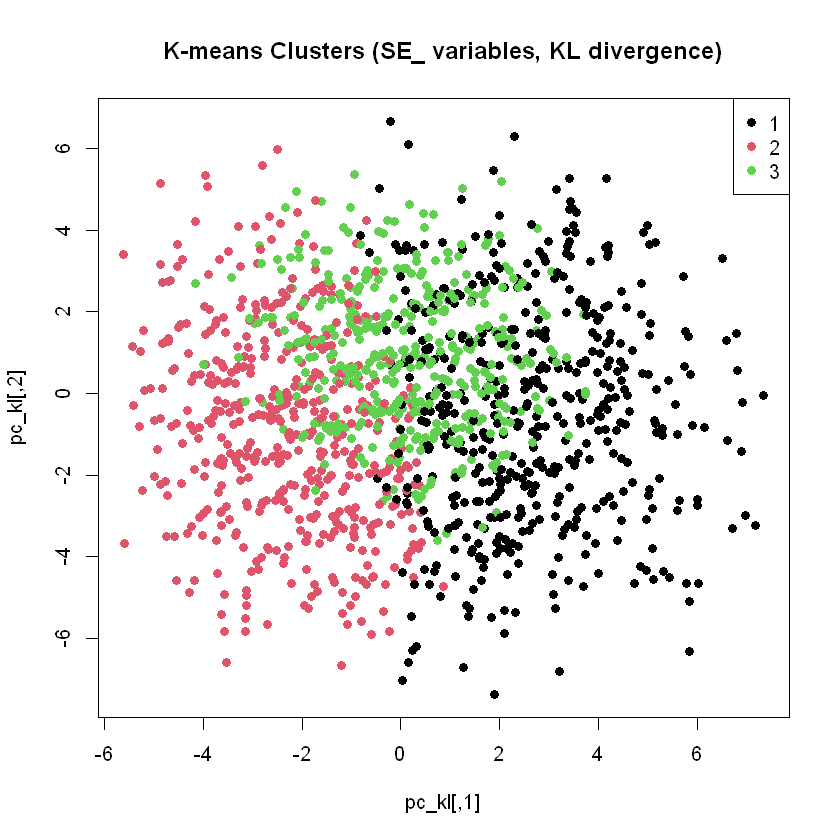

In [17]:
# Kullback-Leibler (KL) divergence-based dissimilarity for k-means clustering

suppressPackageStartupMessages(library(caret))

# One-hot encode SE_ variables (excluding cluster columns)
se_vars_kl <- df[, grepl("^SE_", names(df))]
se_vars_kl[] <- lapply(se_vars_kl, as.factor)
se_vars_kl <- se_vars_kl[, !names(se_vars_kl) %in% c("SE_GCHI", "SE_CHI", "SE_LA", "SE_SN", "SE_PC", "SE_MP", "SE_WT", "SE_PUBT", "SE_PI", "SE_PRIT")]
dummies_kl <- dummyVars(" ~ .", data = se_vars_kl) # Create dummy variables for *all* SE_ variables
se_onehot_kl <- as.data.frame(predict(dummies_kl, newdata = se_vars_kl))

# Add small value to avoid log(0)
epsilon <- 1e-8
se_onehot_kl <- se_onehot_kl + epsilon
se_onehot_kl <- se_onehot_kl / rowSums(se_onehot_kl) # Normalize rows to sum to 1

# KL divergence function (symmetric version)
kl_divergence_sym <- function(p, q) {
    0.5 * (sum(p * log(p / q)) + sum(q * log(q / p)))
}

# Compute KL divergence matrix
n <- nrow(se_onehot_kl)
kl_matrix <- matrix(0, n, n)
for (i in 1:n) {
    for (j in i:n) {
        val <- kl_divergence_sym(as.numeric(se_onehot_kl[i, ]), as.numeric(se_onehot_kl[j, ]))
        kl_matrix[i, j] <- val
        kl_matrix[j, i] <- val
    }
}

# Apply k-means to the KL divergence matrix
set.seed(123)
k <- 3
kmeans_kl <- kmeans(kl_matrix, centers = k, nstart = 10)

# Add cluster assignment to se_vars
se_vars$cluster_kl_kmeans <- as.factor(kmeans_kl$cluster)

# Visualize clusters using first two principal coordinates
pc_kl <- cmdscale(as.dist(kl_matrix), k = 2)
par(bg = "white")
plot(pc_kl, col = se_vars$cluster_kl_kmeans, pch = 19, main = "K-means Clusters (SE_ variables, KL divergence)")
legend("topright", legend = levels(se_vars$cluster_kl_kmeans), col = 1:k, pch = 19)

Warning message:
"Setting row names on a tibble is deprecated."


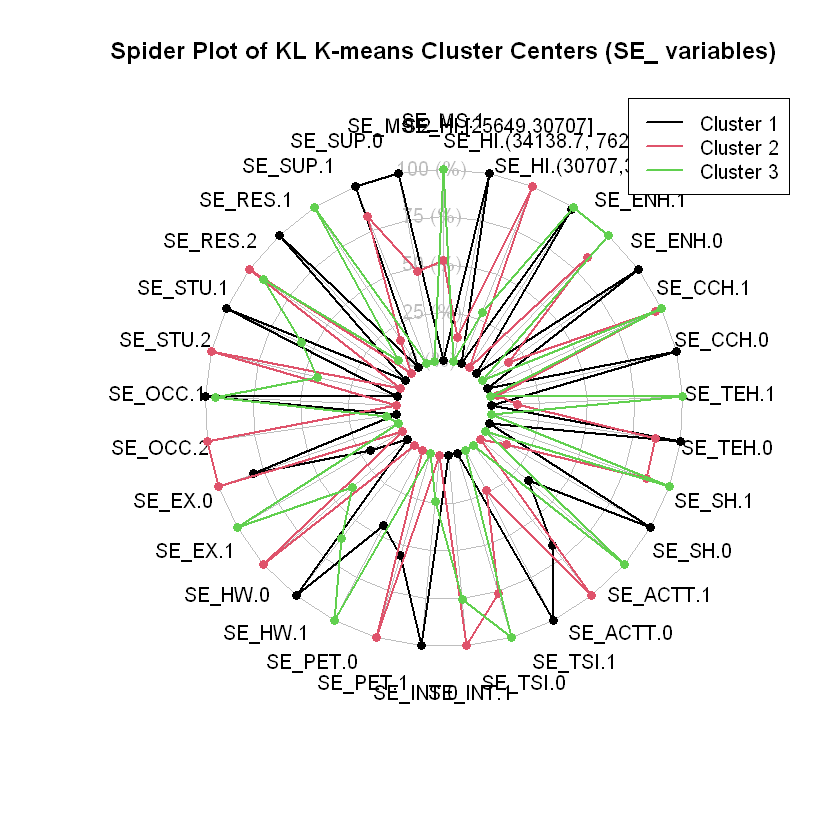

In [18]:
# Spider (radar) plot of cluster centers from Kullback-Leibler k-means clustering

# Prepare data: use the same one-hot encoded data as for KL clustering
# se_onehot_kl and se_vars$cluster_kl_kmeans are already defined

library(fmsb)

# Compute cluster centers (mean of each variable per cluster)
cluster_centers_kl <- se_onehot_kl %>%
    mutate(cluster_kl_kmeans = kmeans_kl$cluster) %>%
    group_by(cluster_kl_kmeans) %>%
    summarise(across(everything(), mean))

# fmsb requires max/min rows
max_vals_kl <- apply(cluster_centers_kl[,-1], 2, max)
min_vals_kl <- apply(cluster_centers_kl[,-1], 2, min)
radar_data_kl <- rbind(max_vals_kl, min_vals_kl, cluster_centers_kl[,-1])

# Set row names for clarity
rownames(radar_data_kl) <- c("Max", "Min", paste0("Cluster_", cluster_centers_kl$cluster_kl_kmeans))

# Plot
par(bg = "white")
radarchart(radar_data_kl, axistype = 1,
           title = "Spider Plot of KL K-means Cluster Centers (SE_ variables)",
           pcol = 1:k, plwd = 2, plty = 1, cglcol = "grey", cglty = 1, axislabcol = "grey")
legend("topright", legend = paste0("Cluster ", cluster_centers_kl$cluster_kl_kmeans), col = 1:k, lty = 1, lwd = 2)

In [19]:
# Print the distribution of OUT_MACE variable for each cluster from KL k-means clustering
cat("\nMACE distribution by clusters:")
mace_by_kl_kmeans_cluster <- table(df$OUT_MACE, se_vars$cluster_kl_kmeans)
print(mace_by_kl_kmeans_cluster)

# Calculate and print percentage of OUT_MACE == 1 for each cluster
cat("\nMACE percentage of occurence by  clusters:\n")
percent_mace1 <- prop.table(mace_by_kl_kmeans_cluster, 2)["1", ] * 100
print(round(percent_mace1, 2))


MACE distribution by clusters:   
      1   2   3
  0 445 526 730
  1 136  95 177

MACE percentage of occurence by  clusters:
    1     2     3 
23.41 15.30 19.51 
